In [34]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from yellowbrick.classifier import ROCAUC
from sklearn.metrics import accuracy_score, confusion_matrix, plot_roc_curve, roc_curve,auc,roc_auc_score

#models
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression 
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.neural_network import MLPClassifier 
from sklearn.tree import DecisionTreeClassifier 
from sklearn.naive_bayes import BernoulliNB
from sklearn.ensemble import GradientBoostingClassifier


from sklearn.metrics import f1_score as f1
from sklearn.metrics import accuracy_score as acs
from sklearn.metrics import auc, roc_auc_score

from ast import literal_eval

#ignore errors
import warnings as wn

from sklearn.feature_selection import RFE, SequentialFeatureSelector

from collections import Counter
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler


wn.filterwarnings('ignore')

In [35]:
colors1 = [    
          (15/255,114/255,255/255,1), # blue 
          (224/255,0/255,193/255,.88), #pink
          (1.0, 0.807843137254902, 0.0392156862745098, 1), #orange
          (0.95, 0, 0, 1), #red
          (0, 0.6666666666666666, 0.6274509803921569, 1), #green
          
          (0, 0.9764705882352941, 0, 0.5), #       
          (10/255,10/255, 130/255, 1), #(0.4, 0.0, 0.6, 1), # green
          (0.6, 0/255, 0.4, 0.8)#
        ]

colors2= [
          (0/255,0/255, 255/255, 1), # dark blue
          (0/255,161/255, 255/255, 1), # blue 
          (61/255,161/255,255/255,1), #light blue
          (124/255, 220/255,255/255,1), #light blue
          (0/255,240/255,255/255,1), #light blue
        ]

colors2= [
          (10/255,10/255, 130/255, 1), # light blue
          (10/255,10/255, 160/255, 1),
          (10/255,10/255, 190/255, 1),
          (10/255,10/255, 220/255, 1),
          (10/255,10/255, 250/255, 1), # dark blue
          
        ]

colors3 = [
          (224/255,0/255,193/255,.88), #pink
          (70/255,70/255, 70/255, 1), #gray
          (15/255,114/255,255/255,1), # blue 
          (0.95, 0, 0, 1), #red
          ]

In [50]:
data = pd.read_csv('https://raw.githubusercontent.com/lucas-fpaiva/AnalisePred_I/main/Projeto/car_eval/data_processed.csv', index_col=0)
results = pd.read_csv("https://raw.githubusercontent.com/lucas-fpaiva/AnalisePred_I/main/Projeto/car_eval/Car_results_plus.csv",index_col=0)
features = data.columns[1:-2]

### Melhores modelos usando seleção de hiperparâmetros

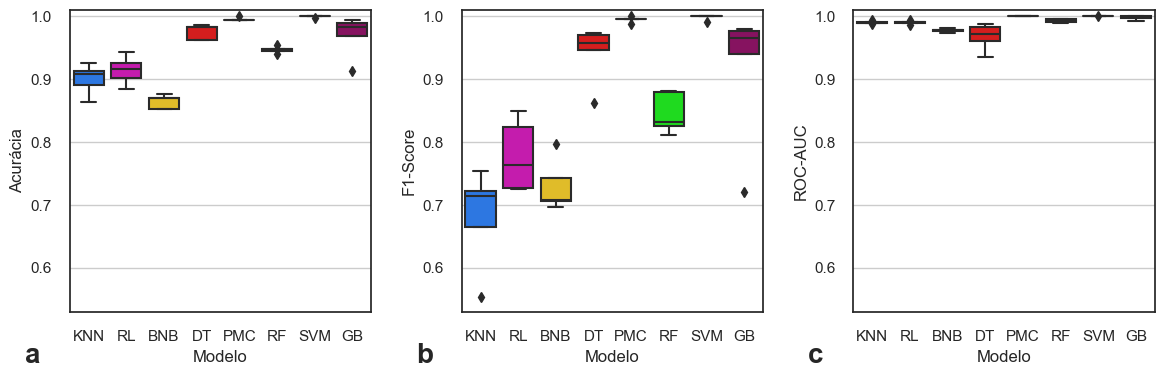

In [54]:
balances = results.Balanceamento.unique()
n_features = results.N_feat.unique()
metrics =results.columns[0:-6]
models_name = results.Modelo.unique()
sns.set_theme(style="white", palette=None)
r = [0,0,0]
c = [0,1,2]
im = ['a','b','c','d']

for balan in balances[0:1]:
    for n_feat in n_features[0:1]:
        fig = plt.figure(figsize = (14,4),dpi=100)
        axes = gridspec.GridSpec(nrows=1, ncols=3, figure=fig, wspace=0.3, hspace=0)
        count=0
        for metric in metrics:
            results_=results[results.Balanceamento==balan]
            results_=results_[results_.N_feat==n_feat]
            
            ax = fig.add_subplot(axes[r[count],c[count]])
            ax.grid()
            sns.boxplot(y=results_[metric],x=results_['Modelo'],ax=ax,palette=colors1)
            ax.text(-0.15, -0.17, im[count], size=20, weight='bold', transform=ax.transAxes)
            ax.set_ylim([0.53,1.01])
            # if count ==1:
            #     ax.set_title('Balanceamento: '+balan+' - Nº de Features: '+str(n_feat)+'\n',fontsize=14)
            count+=1
plt.savefig('fig_metrics.pdf', format="pdf", dpi=1000, bbox_inches="tight")

### Efeito da seleção de features e balanceamento no desempenho dos modelos

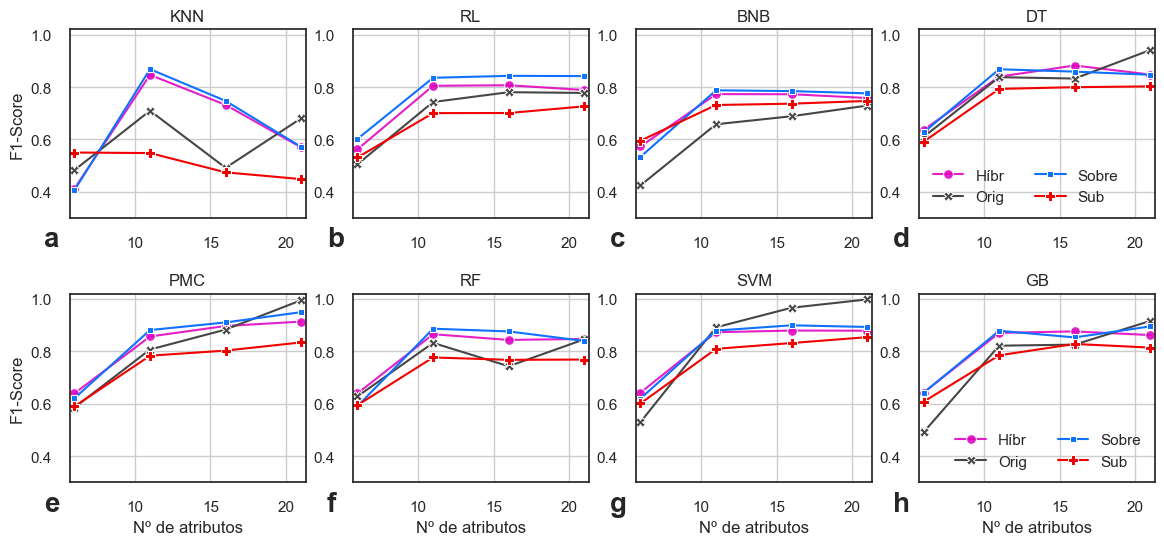

In [58]:
fig = plt.figure(figsize = (14,6),dpi=100)
axes = gridspec.GridSpec(nrows=2, ncols=4,wspace=0.2,hspace=0.4)

r = [0,0,0,0,1,1,1,1]
c = [0,1,2,3,0,1,2,3]

# models_name =["KNN", "RL", "BNB", "DT", "PMC",  "RF"]      #, "DT", "PMC", "SVM", "RF", "GB"
im = ['a','b','c','d','e','f','g','h']
count=0

balances = ['No','Under', 'Over', 'Hybrid']
n_features = [21,16,11,6]
balan = 'No'
metric = 'F1-Score'
count = 0
for modelo in models_name:

    results_=results[results.Modelo==modelo].groupby(by=['N_feat','Balanceamento']).mean().reset_index()
    
    ax = fig.add_subplot(axes[r[count],c[count]])
    ax.grid()
    sns.lineplot(data=results_,x='N_feat',y=metric,hue = 'Balanceamento', ax=ax,palette=colors3,
                 markers=True, linewidth=1.5, style='Balanceamento',markersize=7,dashes=False)#,palette=colors1 ,err_style='bars'
    ax.text(-0.11, -0.15, im[count], size=20, weight='bold', transform=ax.transAxes)
    ax.set_xlim([5.7,21.3])
    ax.set_ylim([0.3,1.02])
    ax.set_title(modelo)
    
    if count in [3,7]:
        ax.legend(['Híbr','Orig', 'Sobre', 'Sub'],ncol=2)   
    else: 
      ax.legend(ncol=6).remove()
    
    if count in [0,4]:
        ax.set_ylabel('F1-Score')
    else: ax.set_ylabel('')
      
    if count in [4,5,6,7]:
        ax.set_xlabel('Nº de atributos')
    else: ax.set_xlabel('')
    count+=1
plt.savefig('fig_resumo.pdf', format="pdf", dpi=1000, bbox_inches="tight")

#### Efeito independente da seleção de features

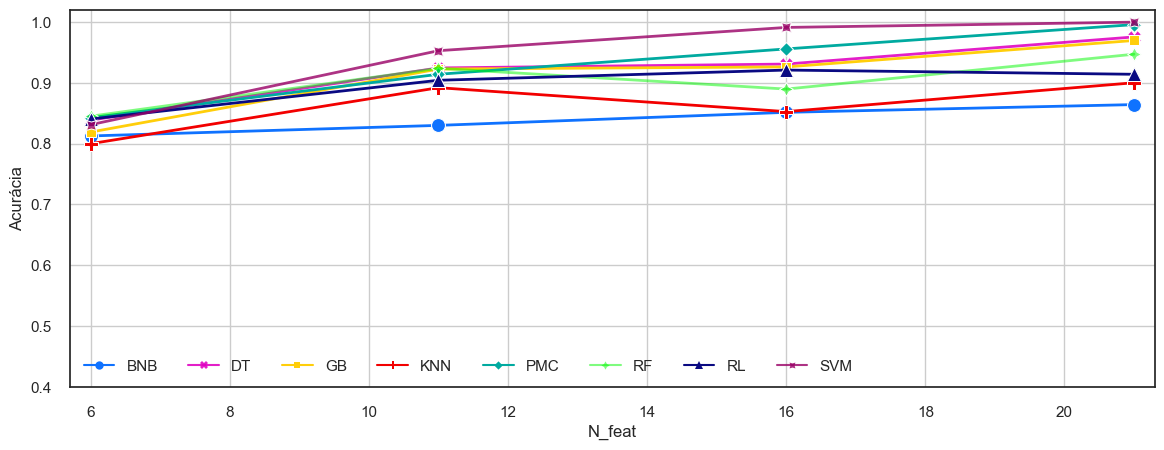

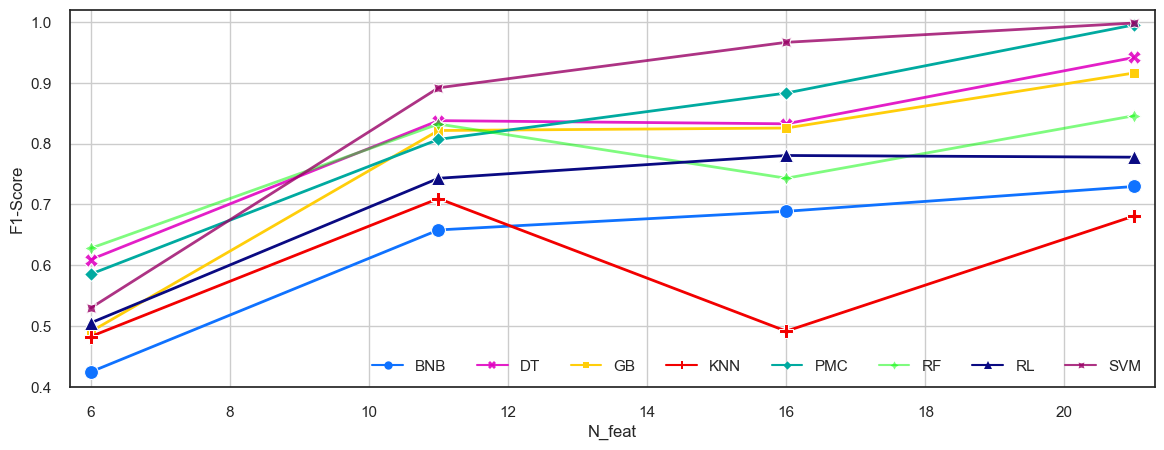

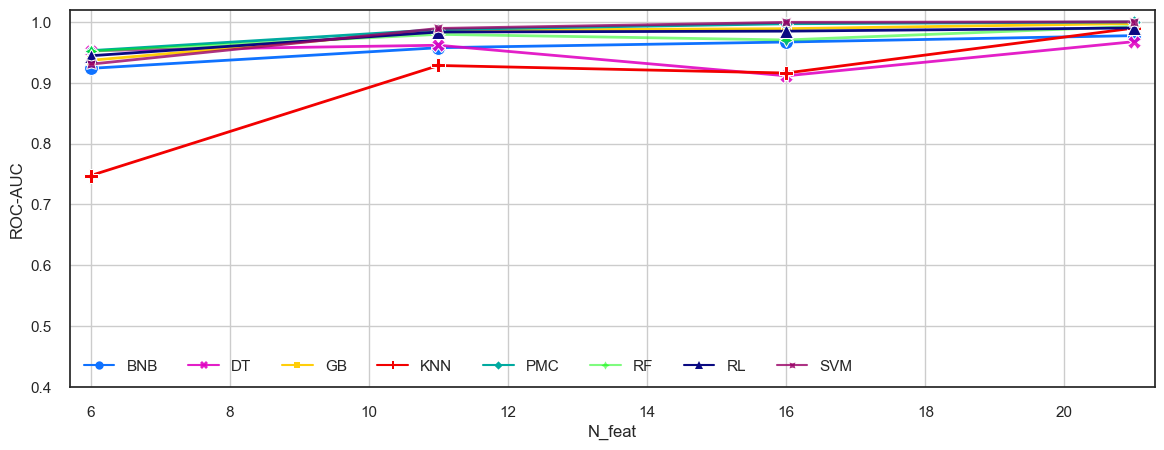

In [8]:
balances = ['No']#['No','Under', 'Over', 'Hybrid']
n_features = [21,16,11,6]
metrics =results.columns[0:-6]
sns.set_theme(style="white", palette=None)
r = [0,0,0]
c = [0,1,2]
im = ['a','b','c','d']
balan = 'No'
for balan in balances:
    
    for metric in metrics:
        fig = plt.figure(figsize = (14,5),dpi=100)
        axes = gridspec.GridSpec(nrows=1, ncols=1, figure=fig, wspace=0.2, hspace=0)
        count=0
        results_=results[results.Balanceamento==balan].groupby(by=['N_feat','Balanceamento','Modelo']).mean().reset_index()
        #results_=results_[results_.N_feat==n_feat]
        
        ax = fig.add_subplot(axes[r[count],c[count]])
        ax.grid()
        sns.lineplot(data=results_,x='N_feat',y=metric,hue = 'Modelo', ax=ax,palette=colors1,markers=True, linewidth=2, style="Modelo",markersize=10,dashes=False)#,palette=colors1 ,err_style='bars'
        # ax.text(-0.15, -0.2, im[count], size=20, weight='bold', transform=ax.transAxes)
        ax.set_xlim([5.7,21.3])
        ax.set_ylim([0.4,1.02])
        ax.legend(ncol=8)
        count+=1
#plt.savefig('fig_metrics.pdf', format="pdf", dpi=1000, bbox_inches="tight")

#### Efeito independente do balanceamento das classes no desempenho dos modelos

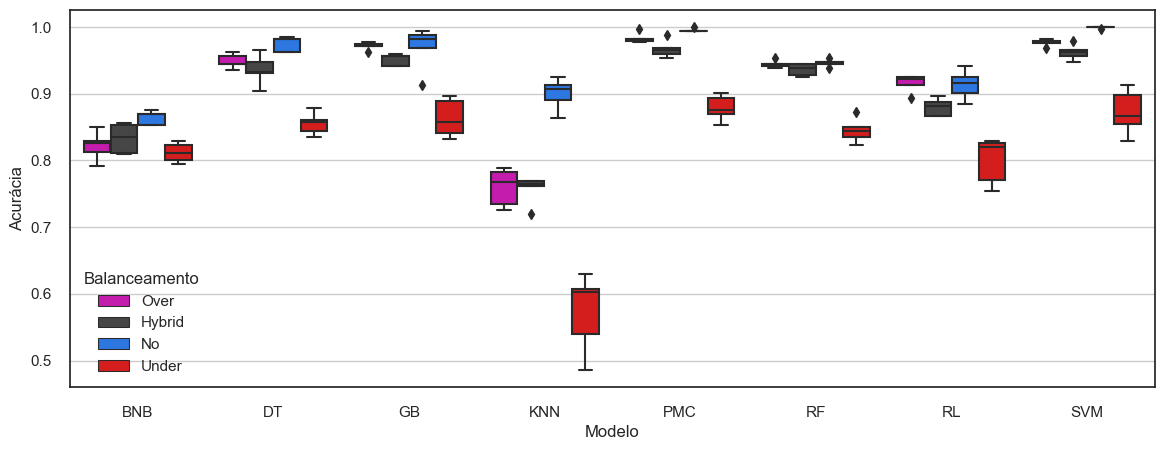

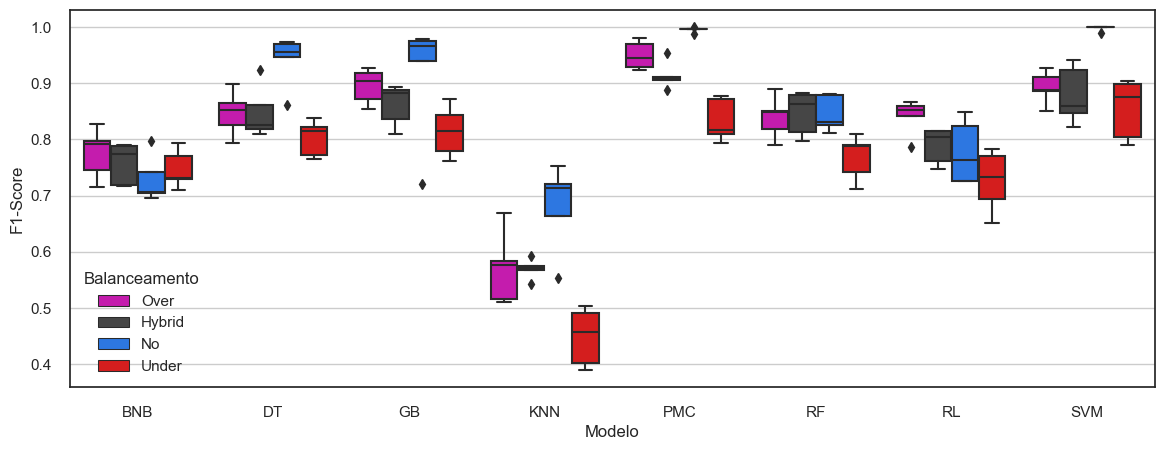

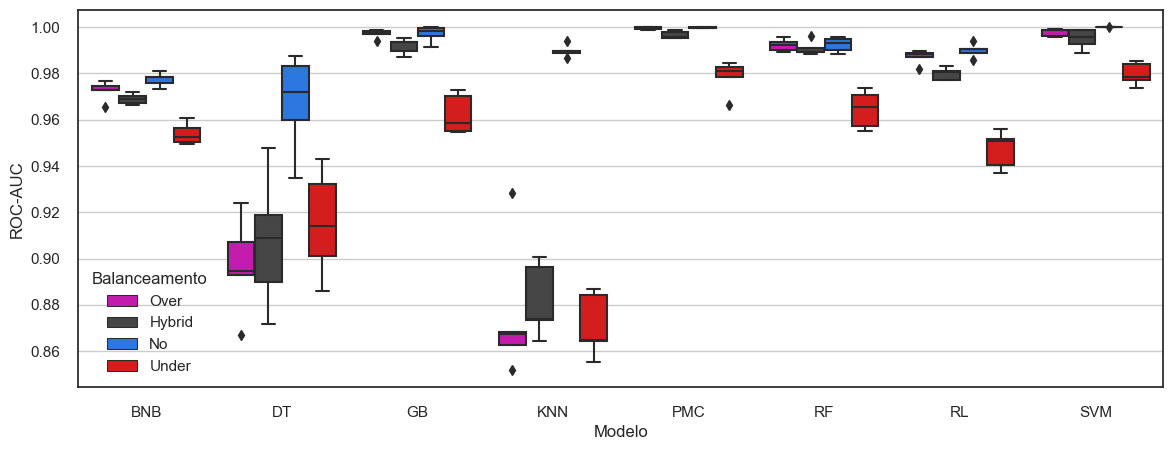

In [9]:
balances = ['No','Under', 'Over', 'Hybrid']
n_features = [21]#[21,16,11,6]

for n_feat in n_features:
    
    for metric in metrics:
        fig = plt.figure(figsize = (14,5),dpi=100)
        axes = gridspec.GridSpec(nrows=1, ncols=1, figure=fig, wspace=0.2, hspace=0)
        count=0
        
        results_=results[results.N_feat==n_feat].sort_values('Modelo')
        
        ax = fig.add_subplot(axes[r[count],c[count]])
        ax.grid()
        sns.boxplot(data=results_,x='Modelo',y=metric,hue ='Balanceamento' , ax=ax,palette=colors3)#, style="Modelo",markersize=10,dashes=False)#,palette=colors1 ,err_style='bars'
        
        count+=1
#plt.savefig('fig_metrics.pdf', format="pdf", dpi=1000, bbox_inches="tight")

### Encontrando os melhores modelos para F1-score sem balanceamento e seleção de features

In [39]:
#pegando os melhor de cada modelo pela média dos folds na acurácia
best_models = results[results.Balanceamento=='No']
best_models = best_models [best_models .N_feat==21]
best_models = best_models.groupby(['Modelo','Balanceamento','N_feat']).mean().reset_index()
best_models = best_models.groupby(['Modelo']).apply(lambda x: x[x['F1-Score'] == x['F1-Score'].max()]).reset_index(drop=True)
best_models.sort_values(by=['Acurácia','F1-Score','ROC-AUC'],ascending=False).head(50)

,Modelo,Balanceamento,N_feat,Acurácia,F1-Score,ROC-AUC,Fold
7,SVM,No,21,0.999422,0.997949,0.999974,3
4,PMC,No,21,0.995369,0.994954,0.999736,3
1,DT,No,21,0.975114,0.941357,0.967378,3
2,GB,No,21,0.969295,0.915909,0.997089,3
5,RF,No,21,0.946760,0.845716,0.992337,3
6,RL,No,21,0.913772,0.777618,0.989875,3
3,KNN,No,21,0.899878,0.680976,0.989685,3
0,BNB,No,21,0.864014,0.729482,0.977262,3


#### Modelos com maiores f1_scores

In [40]:
#pegando os melhor de cada modelo pela média dos folds na acurácia
best_models_f1 = results.groupby(['Modelo','Balanceamento','N_feat']).mean().reset_index()
best_models_f1 = best_models_f1.groupby(['Modelo']).apply(lambda x: x[x['F1-Score'] == x['F1-Score'].max()]).reset_index(drop=True)
best_models_f1.sort_values(by=['Acurácia','F1-Score','ROC-AUC'],ascending=False).head(50)

,Modelo,Balanceamento,N_feat,Acurácia,F1-Score,ROC-AUC,Fold
7,SVM,No,21,0.999422,0.997949,0.999974,3
4,PMC,No,21,0.995369,0.994954,0.999736,3
1,DT,No,21,0.975114,0.941357,0.967378,3
2,GB,No,21,0.969295,0.915909,0.997089,3
5,RF,Over,11,0.950815,0.886236,0.987264,3
3,KNN,Over,11,0.950224,0.868214,0.977037,3
6,RL,Over,16,0.911467,0.842811,0.986117,3
0,BNB,Over,11,0.844343,0.787673,0.968687,3


#### Observando os modelos que melhoram usando seleção de features e balanceamento 

In [41]:
best_models_all = pd.concat([best_models, best_models_f1]).drop_duplicates().reset_index(drop=True)
best_models_all['id'] = best_models_all['Modelo'] + best_models_all['Balanceamento'] + best_models_all['N_feat'].astype(str)
best_models_all

,Modelo,Balanceamento,N_feat,Acurácia,F1-Score,ROC-AUC,Fold,id
0,BNB,No,21,0.864014,0.729482,0.977262,3,BNBNo21
1,DT,No,21,0.975114,0.941357,0.967378,3,DTNo21
2,GB,No,21,0.969295,0.915909,0.997089,3,GBNo21
3,KNN,No,21,0.899878,0.680976,0.989685,3,KNNNo21
4,PMC,No,21,0.995369,0.994954,0.999736,3,PMCNo21
5,RF,No,21,0.946760,0.845716,0.992337,3,RFNo21
6,RL,No,21,0.913772,0.777618,0.989875,3,RLNo21
7,SVM,No,21,0.999422,0.997949,0.999974,3,SVMNo21
8,BNB,Over,11,0.844343,0.787673,0.968687,3,BNBOver11
9,KNN,Over,11,0.950224,0.868214,0.977037,3,KNNOver11


### Obtendo média e desvio padrão dos melhores modelos

In [42]:
results['id']=results['Modelo'] + results['Balanceamento'] + results['N_feat'].astype(str)
ids = best_models_all.id
final_best = results[results['id'].isin(ids)]

In [43]:
tabel = final_best.groupby(['id','Modelo','Balanceamento']).mean().round(decimals=3).astype(str) + '$\pm$' + final_best.groupby(['id','Modelo','Balanceamento']).std().round(decimals=3).astype(str)
tabel = tabel.reset_index()
tabel = tabel[["Modelo","Balanceamento","N_feat","F1-Score","Acurácia", "ROC-AUC"]]
tabel

,Modelo,Balanceamento,N_feat,F1-Score,Acurácia,ROC-AUC
0,BNB,No,21$\pm$0.0,0.729$\pm$0.041,0.864$\pm$0.011,0.977$\pm$0.003
1,BNB,Over,11$\pm$0.0,0.788$\pm$0.043,0.844$\pm$0.016,0.969$\pm$0.006
2,DT,No,21$\pm$0.0,0.941$\pm$0.046,0.975$\pm$0.012,0.967$\pm$0.021
3,GB,No,21$\pm$0.0,0.916$\pm$0.111,0.969$\pm$0.033,0.997$\pm$0.003
4,KNN,No,21$\pm$0.0,0.681$\pm$0.078,0.9$\pm$0.024,0.99$\pm$0.003
5,KNN,Over,11$\pm$0.0,0.868$\pm$0.06,0.95$\pm$0.015,0.977$\pm$0.005
6,PMC,No,21$\pm$0.0,0.995$\pm$0.005,0.995$\pm$0.003,1.0$\pm$0.0
7,RF,No,21$\pm$0.0,0.846$\pm$0.032,0.947$\pm$0.005,0.992$\pm$0.003
8,RF,Over,11$\pm$0.0,0.886$\pm$0.034,0.951$\pm$0.011,0.987$\pm$0.013
9,RL,No,21$\pm$0.0,0.778$\pm$0.057,0.914$\pm$0.022,0.99$\pm$0.003


In [15]:
print(tabel.to_latex(escape=False,index=False,bold_rows=True,decimal=',',index_names=False))

\begin{tabular}{llllll}
\toprule
Modelo & Balanceamento &      N_feat &         F1-Score &         Acurácia &          ROC-AUC \\
\midrule
   BNB &            No &  21$\pm$0.0 &  0.729$\pm$0.041 &  0.864$\pm$0.011 &  0.977$\pm$0.003 \\
   BNB &          Over &  11$\pm$0.0 &  0.788$\pm$0.043 &  0.844$\pm$0.016 &  0.969$\pm$0.006 \\
    DT &            No &  21$\pm$0.0 &  0.941$\pm$0.046 &  0.975$\pm$0.012 &  0.967$\pm$0.021 \\
    GB &            No &  21$\pm$0.0 &  0.916$\pm$0.111 &  0.969$\pm$0.033 &  0.997$\pm$0.003 \\
   KNN &            No &  21$\pm$0.0 &  0.681$\pm$0.078 &    0.9$\pm$0.024 &   0.99$\pm$0.003 \\
   KNN &          Over &  11$\pm$0.0 &   0.868$\pm$0.06 &   0.95$\pm$0.015 &  0.977$\pm$0.005 \\
   PMC &            No &  21$\pm$0.0 &  0.995$\pm$0.005 &  0.995$\pm$0.003 &      1.0$\pm$0.0 \\
    RF &            No &  21$\pm$0.0 &  0.846$\pm$0.032 &  0.947$\pm$0.005 &  0.992$\pm$0.003 \\
    RF &          Over &  11$\pm$0.0 &  0.886$\pm$0.034 &  0.951$\pm$0.011 &  0.987$\

### Gerando matriz de confusão média e curva roc média por modelo

In [44]:
def models (name,parameters):
    if name == 'DT':
        model = DecisionTreeClassifier(**parameters);
    elif name == 'RF':
        model = RandomForestClassifier(**parameters);
    elif name == 'KNN':
        model = KNeighborsClassifier(**parameters);
    elif name == 'RL':
        model = LogisticRegression(**parameters);
    elif name == 'SVM':
        model = SVC(**parameters);
    elif name == 'PMC':
        model = MLPClassifier(**parameters);
    elif name == 'BNB':
        model = BernoulliNB(**parameters);
    elif name == 'GB':
        model = GradientBoostingClassifier(**parameters);
    else :
        print('Model not found')
        model=None
    return model


def select_feat(x_treino,y_treino,model,n,features):

  if n =='All' or n==21:
    best_feats = features

  else:
    sfs = SequentialFeatureSelector(model, n_features_to_select=n, direction='backward')
    sfs.fit(x_treino,y_treino)

    sfs.get_support()

    best_feats = sfs.feature_names_in_[sfs.support_]

    #print('n=',n, len(best_feats),best_feats)
    #print('best_feats = features[rfe.support_]')
    
  return best_feats


def balan_func(X, y,balan_name):
   
  # print("Original Sample ", Counter(y).values())
  
  if balan_name == 'No':
    x_treino, y_treino = treino[features],treino['class']

  elif balan_name == 'Under': 
    rus = RandomUnderSampler(sampling_strategy='not minority', replacement=True, random_state=0) #replacement considera independentemente cada classe
    x_treino, y_treino = rus.fit_resample(X, y)
    # print("UnderSampling ", x_treino.shape,y_treino.shape, Counter(y_treino).values())

  elif balan_name == 'Over': ## Falta atualizar
    x_treino, y_treino = SMOTE(sampling_strategy='not majority').fit_resample(X, y)   
    # print("OverSampling ", Counter(y_treino).values())

  elif balan_name == 'Hybrid': ## Falta atualizar
    classes = {0:450, 1:307, 2:52, 3:55} 
    rus = RandomUnderSampler(sampling_strategy=classes, replacement=True, random_state=0) #replacement considera independentemente cada classe
    X, y = rus.fit_resample(X, y)
    x_treino, y_treino = SMOTE(sampling_strategy='not majority').fit_resample(X, y)  
    # print("HybridSampling ",  Counter(y_treino).values())
  
  else :
    print(balan_name)

  return x_treino, y_treino



def metrics (y_true, y_pred, y_pred_prob):
  return [acs(y_true, y_pred), f1(y_true, y_pred, average = 'macro'),
          roc_auc_score(y_true, y_pred_prob, average='macro', multi_class = 'ovr')]

### Matriz média melhores modelos

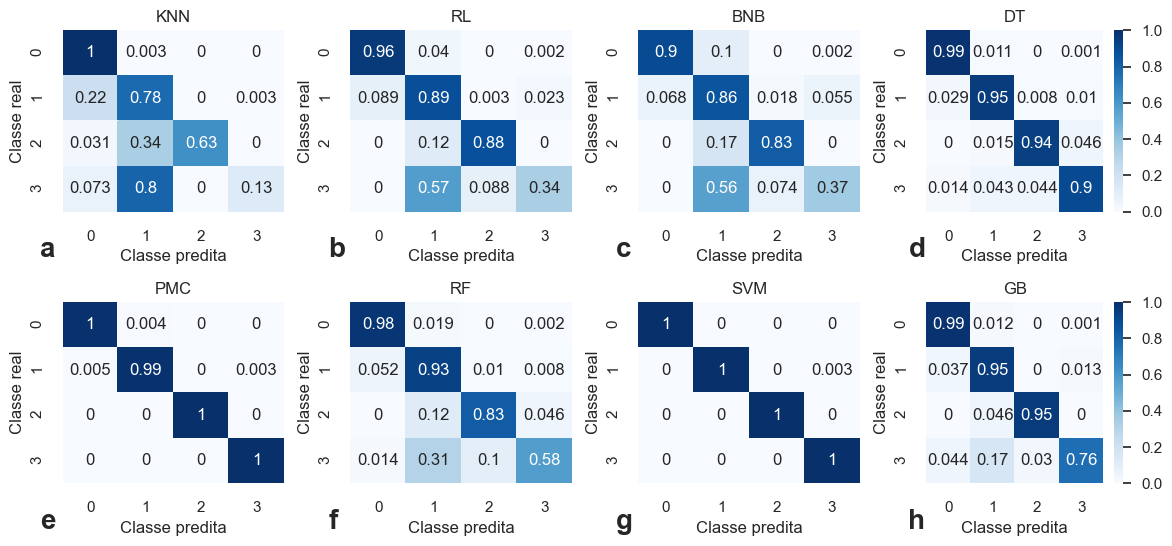

In [131]:
fig = plt.figure(figsize = (14,6),dpi=100)
axes = gridspec.GridSpec(nrows=2, ncols=4,wspace=0.3,hspace=0.5)
models_name = results.Modelo.unique()

r = [0,0,0,0,1,1,1,1]
c = [0,1,2,3,0,1,2,3]

# models_name =["KNN", "RL", "BNB", "DT", "PMC",  "RF"]      #, "DT", "PMC", "SVM", "RF", "GB"
im = ['a','b','c','d','e','f','g','h']
count=0
for name in models_name:
  conf_mean = 0
  for k in range(1,6):
    treino = data[data.fold!=k]
    teste  = data[data.fold==k]
    
    x_treino = treino[features]
    y_treino = treino['class']

    x_teste = teste[features]
    y_teste = teste['class']
    
    res_model = results[results["Modelo"]==name ]
    res_model = res_model[res_model.Balanceamento=='No']
    res_model = res_model [res_model.N_feat==21]
    
    parameters = literal_eval(res_model[res_model.Fold==k]['Parâmetros'].values[0])

    model = models(name,parameters);
    model.fit(x_treino, y_treino);
    y_pred = model.predict(x_teste);
    
    y_pred_prob = model.predict_proba(x_teste)
    # result_ = metrics(y_teste, y_pred, y_pred_prob)
    
    # print("Modelo:", name, "Fold:", k, "Balanceamento:", balan, "Features:", n_feat)
    # print("Acc:", result_[0], "F1:", result_[1], "AUC:", result_[2])
        
    conf_mean = conf_mean + confusion_matrix(y_teste, y_pred,normalize='true')
    
  conf_mean = np.round(conf_mean/5,3)
  
  ax = fig.add_subplot(axes[r[count],c[count]])
  ax.set_title(name)
  if count == 3 or count==7:
    sns.heatmap(conf_mean, annot=True,ax=ax,cmap='Blues', vmin=0, vmax=1)
  else:
    sns.heatmap(conf_mean, annot=True,ax=ax,cmap='Blues',cbar=False, vmin=0, vmax=1)
    
  ax.text(-0.1, -0.25, im[count], size=20, weight='bold', transform=ax.transAxes)
  ax.set_xlabel('Classe predita')
  ax.set_ylabel('Classe real')
  
  
  count+=1
plt.savefig('fig_confusion.pdf', format="pdf", dpi=1000, bbox_inches="tight")
plt.show()

### Diferença das matrizes de confusão para os modelos que melhoraram o f1-score


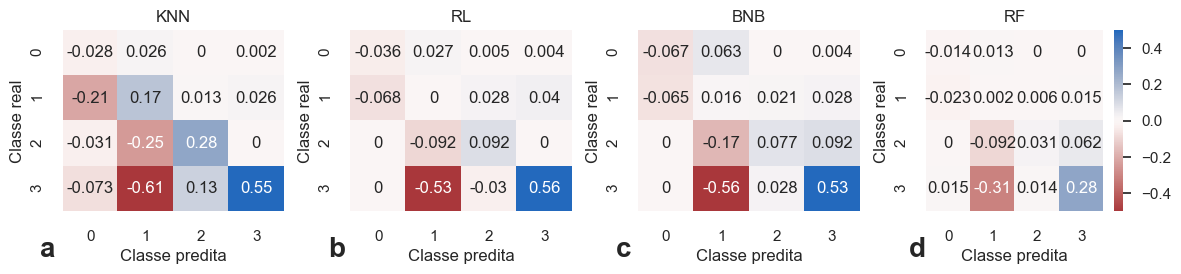

In [133]:
fig = plt.figure(figsize = (14,6),dpi=100)
axes = gridspec.GridSpec(nrows=2, ncols=4,wspace=0.3,hspace=0.5)

r = [0,0,1,1]
c = [0,1,0,1]

models_name =["KNN", "KNN","RL","RL","BNB","BNB","RF","RF"]      #, "DT", "PMC", "SVM", "RF", "GB"
feats = [21,11,21,16,21,11,21,11]
balans = ['No','Over','No','Over','No','Over','No','Over']

# im = ['a','b','c','d']#,'e','f','g','h']

r = [0,0,0,0,1,1,1,1]
c = [0,1,2,3,0,1,2,3]

# models_name =["KNN", "RL", "BNB", "DT", "PMC",  "RF"]      #, "DT", "PMC", "SVM", "RF", "GB"
im = ['a','b','c','d','e','f','g','h']

count=0
conf_mean1 = 0
conf_mean2 = 0
alpha = 1
for n_model in range(0,8):
  
  for k in range(1,6):    
    balan = balans[n_model]
    feat = feats[n_model]
    
    treino = data[data.fold!=k]
    teste  = data[data.fold==k]
    
    x_treino, y_treino = balan_func(treino[features],treino['class'],balan)
  
    # x_teste = teste[features]
    y_teste = teste['class']
    
    # res_model = results[results.Fold==k]
    res_model = results[results.Balanceamento==balan]
    # print(res_model.shape)
    res_model = res_model [res_model.N_feat==feat]
    # print(res_model.shape)
    res_model =res_model[res_model["Modelo"]==models_name[n_model]]
    parameters = literal_eval(res_model[res_model.Fold==k]['Parâmetros'].values[0])
    model = models(models_name[n_model],parameters);
    # print(k, n_model)
    #
    
    # select_feat(x_treino,y_treino,model,n,features)
    if feat ==21:
      best_feat=features.to_list()
    else:
      #best_feat = select_feat(x_treino,y_treino,model,feat,features)
      best_feat = literal_eval(res_model[res_model.Fold==k]['Features'].values[0].replace(' ',','))
    
    #atualizando o treino com as features escolhidas
    x_treino =x_treino[best_feat]
    # print(k,best_feat)
    #definindo o x de teste a partir das features selecionadas
    x_teste = teste[best_feat]
    
    model.fit(x_treino, y_treino);
    y_pred = model.predict(x_teste);
    y_pred_prob = model.predict_proba(x_teste)
    # result_ = metrics(y_teste, y_pred, y_pred_prob)
    
    # print("Modelo:", models_name[n_model], "Fold:", k, "Balanceamento:", balan, "Features:", feat)
    # print("Acc:", result_[0], "F1:", result_[1], "AUC:", result_[2])
    if balan!='Over':
      conf_mean1 = conf_mean1 + confusion_matrix(y_teste, y_pred,normalize='true')
      # print(count,"conf_mean1")
    else:
      # print(count,"conf_mean2")
      conf_mean2 = conf_mean2 + confusion_matrix(y_teste, y_pred,normalize='true')
      # print(count,balan)
    
  # print()  
  if balan=='Over':
    conf_mean = -np.round(conf_mean1/5,3)+np.round(conf_mean2/5,3)
    
    
    ax = fig.add_subplot(axes[r[count],c[count]])
    ax.set_title(models_name[n_model])
    if count == 3 or count==7:
      sns.heatmap(conf_mean, annot=True,ax=ax,cmap="vlag_r", vmin=-0.5, vmax=0.5)
    else:
      sns.heatmap(conf_mean, annot=True,ax=ax,cmap="vlag_r",cbar=False, vmin=-0.5, vmax=0.5)
    
    conf_mean1 = 0
    conf_mean2 = 0
    conf_mean = 0
    
    ax.text(-0.1, -0.25, im[count], size=20, weight='bold', transform=ax.transAxes)
    ax.set_xlabel('Classe predita')
    ax.set_ylabel('Classe real')
    count+=1
  
  
plt.savefig('fig_confusion_plus.pdf', format="pdf", dpi=1000, bbox_inches="tight")
plt.show()

In [89]:
literal_eval(res_model[res_model.Fold==k]['Features'].values[0].replace(' ',','))

['buying_price_vhigh',
 'buying_price_high',
 'buying_price_low',
 'maintenance_price_vhigh',
 'maintenance_price_high',
 'maintenance_price_low',
 'persons_2',
 'persons_4',
 'luggage_boot_size_small',
 'safety_low',
 'safety_high']

In [28]:
# opbservando o desempenho do knn com 11 features e balanceamento over
results.loc[(results.Balanceamento=='Over') & (results.N_feat==11) & (results.Modelo=='KNN')]

,Acurácia,F1-Score,ROC-AUC,Fold,Modelo,Parâmetros,Balanceamento,N_feat,Features,id
10,0.965318,0.906484,0.977917,1,KNN,"{'metric': 'manhattan', 'n_neighbors': 5, 'wei...",Over,11,['buying_price_vhigh' 'buying_price_high' 'buy...,KNNOver11
26,0.945087,0.858257,0.972753,2,KNN,"{'metric': 'manhattan', 'n_neighbors': 5, 'wei...",Over,11,['buying_price_vhigh' 'buying_price_high' 'buy...,KNNOver11
42,0.953757,0.895814,0.984913,3,KNN,"{'metric': 'manhattan', 'n_neighbors': 5, 'wei...",Over,11,['buying_price_vhigh' 'buying_price_high' 'buy...,KNNOver11
58,0.959420,0.913342,0.978530,4,KNN,"{'metric': 'manhattan', 'n_neighbors': 5, 'wei...",Over,11,['buying_price_vhigh' 'buying_price_high' 'buy...,KNNOver11
74,0.927536,0.767172,0.971070,5,KNN,"{'metric': 'manhattan', 'n_neighbors': 5, 'wei...",Over,11,['buying_price_vhigh' 'buying_price_high' 'mai...,KNNOver11


### Parâmetros dos dois melhores modelos

In [5]:
best_models = pd.concat([results[results.Modelo=='SVM'],results[results.Modelo=='PMC']],axis=0)
best_models = best_models.round(decimals=3).astype(str)
print(best_models[['Modelo', 'Parâmetros', 'Acurácia', 'F1-Score','ROC-AUC',"Fold"]].to_latex(escape=False,index=False,bold_rows=True,decimal=',',index_names=False))

\begin{tabular}{llllll}
\toprule
Modelo &                                         Parâmetros & Acurácia & F1-Score & ROC-AUC & Fold \\
\midrule
   SVM &  {'C': 10, 'kernel': 'rbf', 'probability': True... &      1.0 &      1.0 &     1.0 &    1 \\
   SVM &  {'C': 10, 'kernel': 'rbf', 'probability': True... &    0.997 &    0.988 &     1.0 &    1 \\
   SVM &  {'C': 10, 'kernel': 'rbf', 'probability': True... &    0.954 &    0.878 &   0.989 &    1 \\
   SVM &  {'C': 10, 'kernel': 'rbf', 'probability': True... &    0.861 &    0.579 &   0.951 &    1 \\
   SVM &  {'C': 10, 'kernel': 'rbf', 'probability': True... &    0.913 &    0.903 &   0.984 &    1 \\
   SVM &  {'C': 10, 'kernel': 'rbf', 'probability': True... &    0.893 &    0.842 &   0.978 &    1 \\
   SVM &  {'C': 10, 'kernel': 'rbf', 'probability': True... &    0.905 &    0.859 &   0.986 &    1 \\
   SVM &  {'C': 10, 'kernel': 'rbf', 'probability': True... &    0.769 &    0.608 &    0.94 &    1 \\
   SVM &  {'C': 10, 'kernel': 'rbf', 'pr

In [6]:
for model in ['SVM','PMC']:
    for i in range(1,6):
        prov = results[results.Modelo==model]
        print(prov[prov.Fold==i]['Parâmetros'].values)

["{'C': 10, 'kernel': 'rbf', 'probability': True, 'random_state': 0}"
 "{'C': 10, 'kernel': 'rbf', 'probability': True, 'random_state': 0}"
 "{'C': 10, 'kernel': 'rbf', 'probability': True, 'random_state': 0}"
 "{'C': 10, 'kernel': 'rbf', 'probability': True, 'random_state': 0}"
 "{'C': 10, 'kernel': 'rbf', 'probability': True, 'random_state': 0}"
 "{'C': 10, 'kernel': 'rbf', 'probability': True, 'random_state': 0}"
 "{'C': 10, 'kernel': 'rbf', 'probability': True, 'random_state': 0}"
 "{'C': 10, 'kernel': 'rbf', 'probability': True, 'random_state': 0}"
 "{'C': 10, 'kernel': 'rbf', 'probability': True, 'random_state': 0}"
 "{'C': 10, 'kernel': 'rbf', 'probability': True, 'random_state': 0}"
 "{'C': 10, 'kernel': 'rbf', 'probability': True, 'random_state': 0}"
 "{'C': 10, 'kernel': 'rbf', 'probability': True, 'random_state': 0}"
 "{'C': 10, 'kernel': 'poly', 'probability': True, 'random_state': 0}"
 "{'C': 10, 'kernel': 'poly', 'probability': True, 'random_state': 0}"
 "{'C': 10, 'kerne

### Curva roc média

In [13]:
features

Index(['buying_price_vhigh', 'buying_price_high', 'buying_price_med',
       'buying_price_low', 'maintenance_price_vhigh', 'maintenance_price_high',
       'maintenance_price_med', 'maintenance_price_low', 'doors_2', 'doors_3',
       'doors_4', 'doors_5more', 'persons_2', 'persons_4', 'persons_more',
       'luggage_boot_size_small', 'luggage_boot_size_med',
       'luggage_boot_size_big', 'safety_low', 'safety_med', 'safety_high'],
      dtype='object')

IndexError: index 0 is out of bounds for axis 0 with size 0

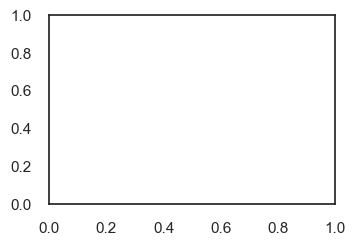

In [85]:
fig = plt.figure(figsize = (14,6),dpi=100)
axes = gridspec.GridSpec(nrows=2, ncols=3,wspace=0.4,hspace=0.4)

r = [0,0,0,1,1,1]
c = [0,1,2,0,1,2]

im = ['a','b','c','d','e','f','g','h']
count=0
name='KNN'
auc_ = []
for k in range(1,7):
  ax = fig.add_subplot(axes[r[count],c[count]])
  
  if k<6:
    treino = data[data.fold!=k]
    teste  = data[data.fold==k]
    
    x_treino = treino[features]
    y_treino = treino['class']

    x_teste = teste[features]
    y_teste = teste['class']
    
    res_model = results[results.Modelo==name]
    parameters = literal_eval(res_model[res_model.Fold==k]['Parâmetros'].values[0])

    model = models(name,parameters);
  
    visualizer = ROCAUC(model, classes=["0", "1", "2", "3"],ax=ax,micro=False, macro=False)
    visualizer.fit(x_teste, y_teste)        # Fit the training data to the visualizer
    auc_.append(visualizer.score(x_teste, y_teste,))       # Evaluate the model on the test data
    #ax.set_xlim([-0.001,0.02])
    #ax.set_ylim([0.98,1.001])
    ax.set_xlabel('Falsos positivos')
    ax.set_ylabel('Verdadeiros positivos')
    ax.legend()
  
  
  else:
    sns.boxplot(x=auc_,ax=ax)
    ax.set_xlabel('AUC (fold)')
  ax.text(-0.1, -0.2, im[count], size=14, weight='bold', transform=ax.transAxes)
  
  count+=1
# plt.savefig('fig_roc.pdf', format="pdf", dpi=1000, bbox_inches="tight")
plt.show()

### Vizualizando o modelo DT

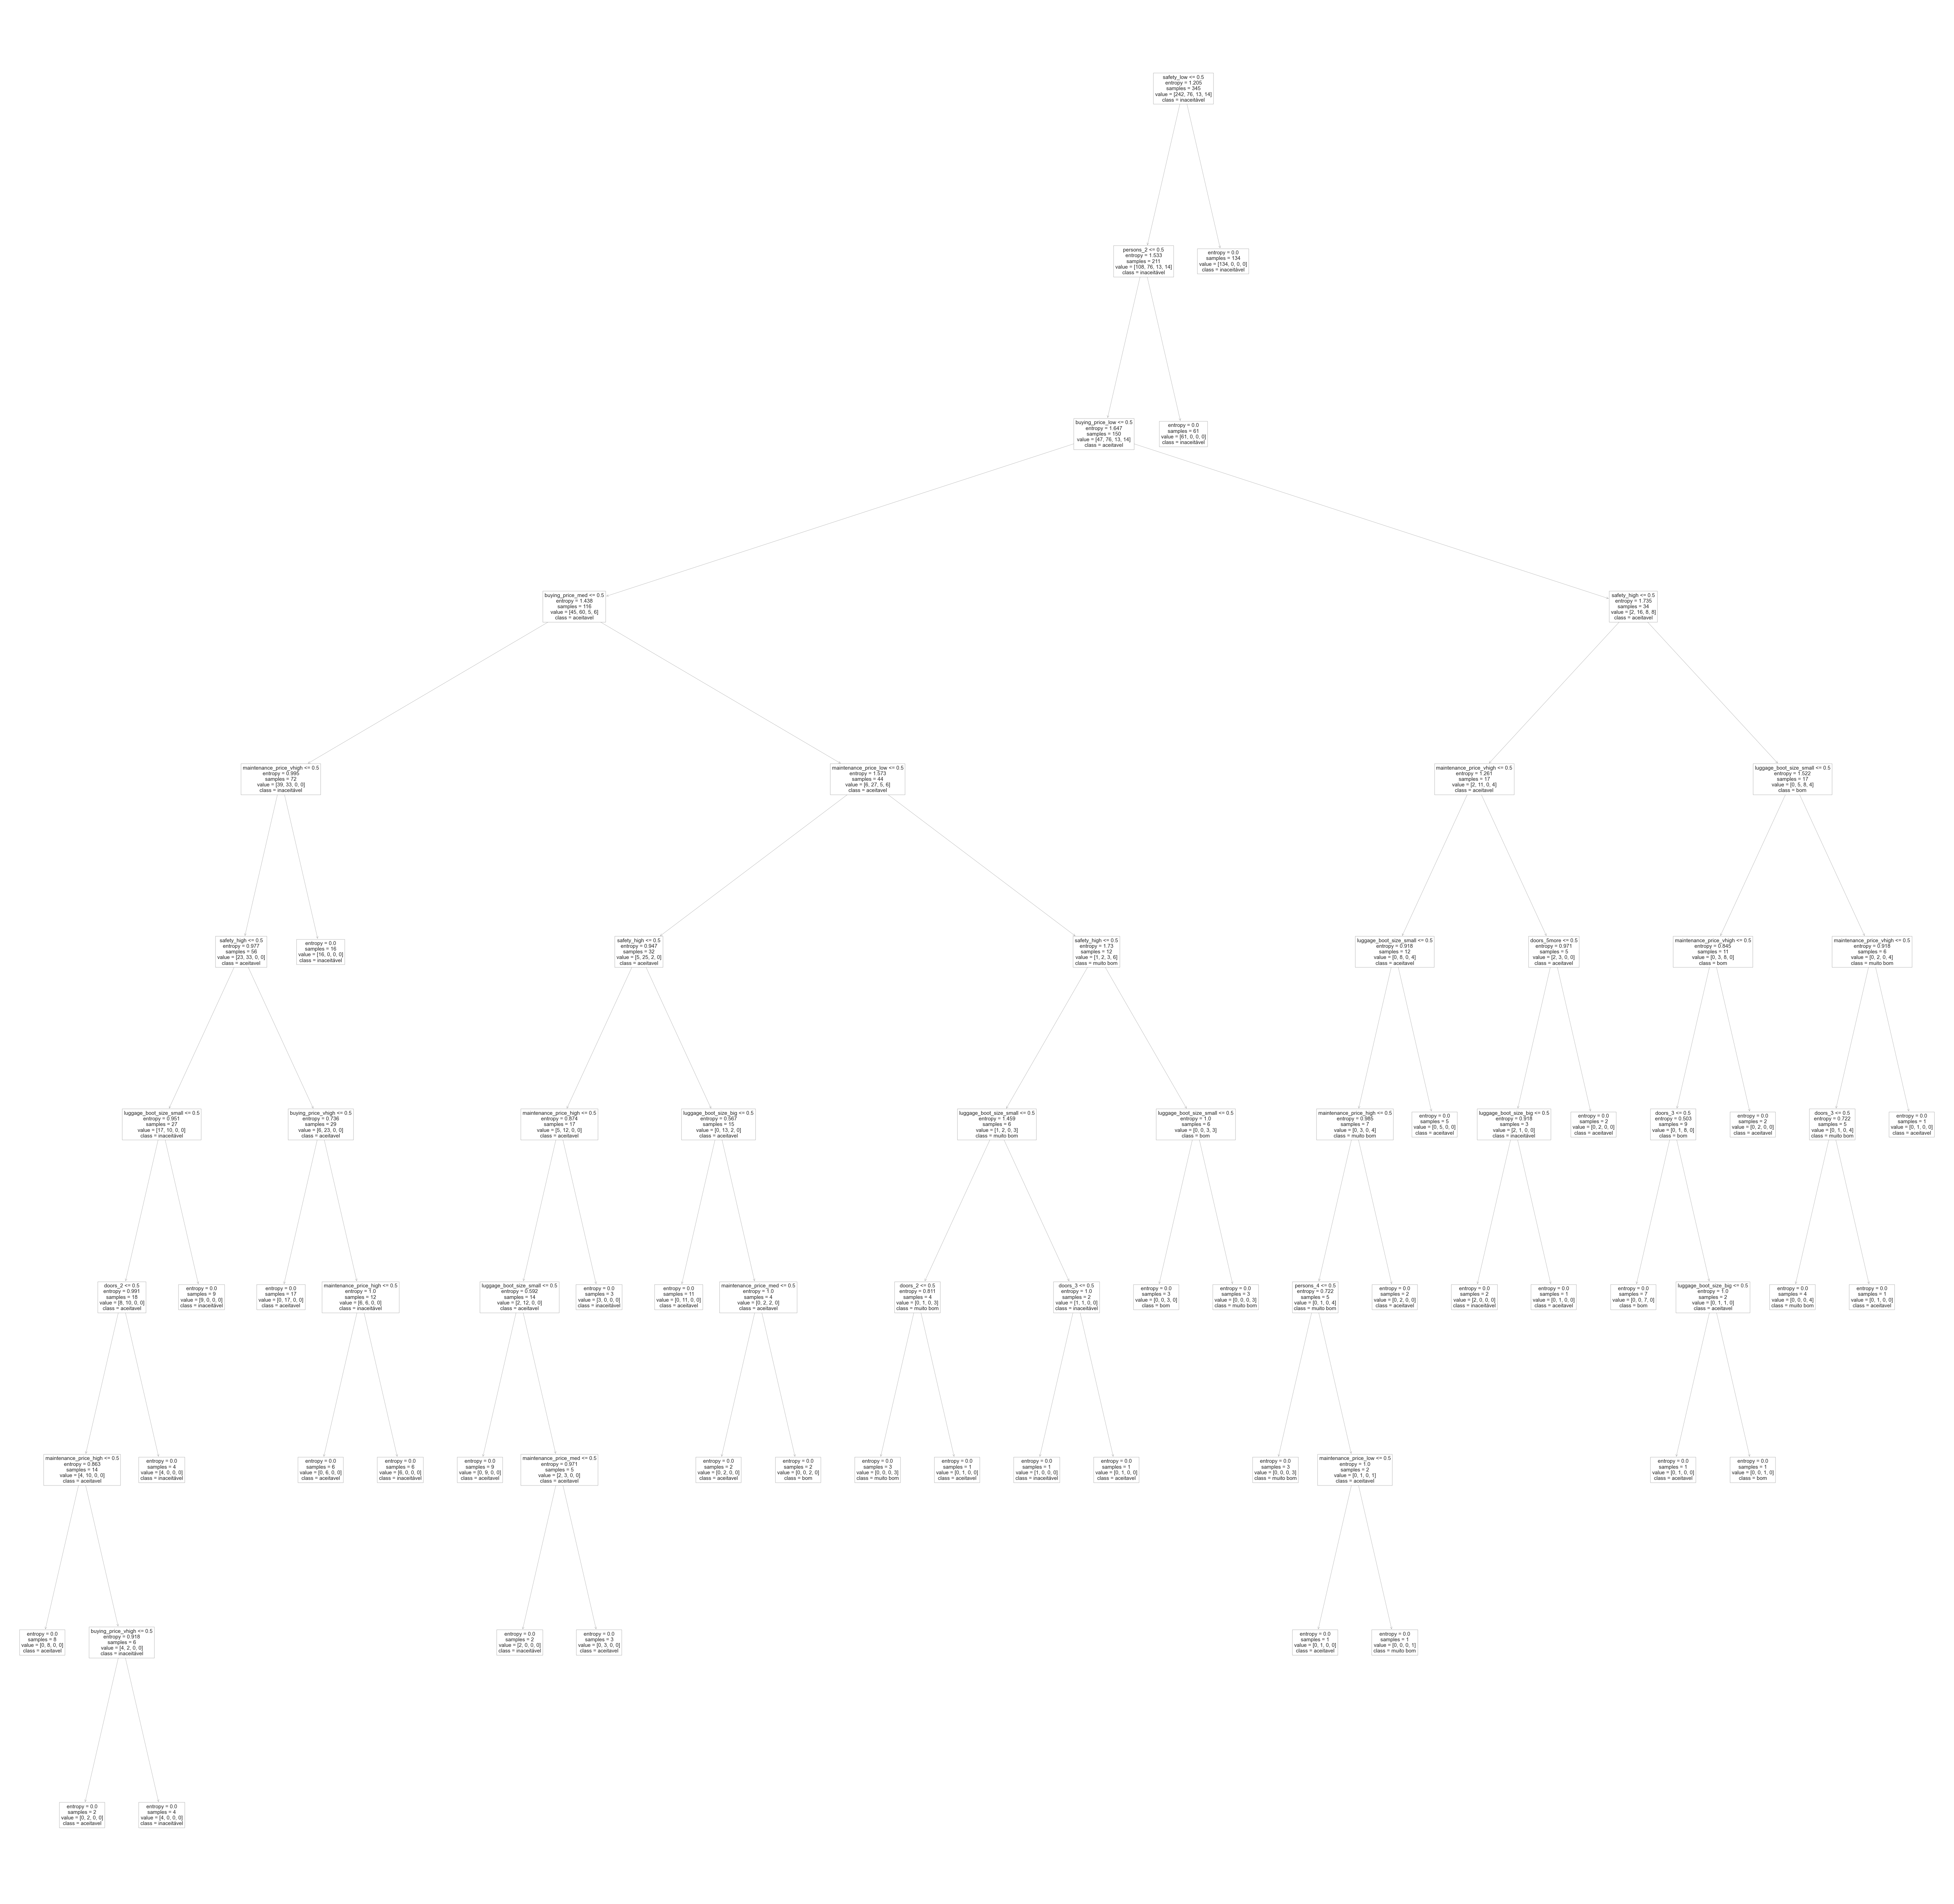

In [15]:
from sklearn.tree import  plot_tree
plt.figure(figsize=(100,100))
plot_tree(model,feature_names=features,class_names=['inaceitável','aceitavel','bom','muito bom'])
plt.savefig('tree.pdf',dp1=1000,bbbox_inches="tight")